In [42]:
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
import mani_skill.envs
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_checker import check_env
from mani_skill.utils import gym_utils
from mani_skill.utils.wrappers.record import RecordEpisode
from mani_skill.vector.wrappers.sb3 import ManiSkillSB3VectorEnv
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio

SEED = 17
NUM_ENVS = 8
total_timesteps = 100000


In [43]:
def run_ppo(env, total_timesteps, policy = "MlpPolicy", learning_rate = 3e-4, model_name = ""):
    ppo_model = PPO(policy = policy, env = env, learning_rate = learning_rate, n_steps = 2048, batch_size = 64, n_epochs = 10, gamma = 0.99, gae_lambda = .95,
    clip_range = .2, verbose = 1, seed = SEED)
    ppo_model.learn(total_timesteps = total_timesteps, progress_bar = True)
    ppo_model.save(model_name)

In [44]:
env = gym.make("CartPole-v1", render_mode = "rgb_array")
states, _ = env.reset(seed = SEED, options = {"low": -0.1, "high": 0.1})
check_env(env, warn = True)

In [45]:
run_ppo(env, total_timesteps, learning_rate = .01, model_name = "ppo_.01")
run_ppo(env, total_timesteps, learning_rate = 1e-3, model_name = "ppo_1e-3")
run_ppo(env, total_timesteps, learning_rate = 1e-6, model_name = "ppo_1e-6")

c:\Users\yzwan\anaconda3\envs\Tree-sitter\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 20.9     |
| time/              |          |
|    fps             | 1938     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29.8        |
|    ep_rew_mean          | 29.8        |
| time/                   |             |
|    fps                  | 1126        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017804498 |
|    clip_fraction        | 0.326       |
|    clip_range           | 0.2         |
|    entropy_loss   

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 20.9     |
| time/              |          |
|    fps             | 2115     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 32.2       |
|    ep_rew_mean          | 32.2       |
| time/                   |            |
|    fps                  | 1424       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01379199 |
|    clip_fraction        | 0.204      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.68

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 20.9     |
| time/              |          |
|    fps             | 2126     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 22.6          |
|    ep_rew_mean          | 22.6          |
| time/                   |               |
|    fps                  | 1427          |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 2.7935894e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2       

In [46]:
def get_average(model_name, iterations = 100):

    success_rates_list = []

    num_envs = 4
    max_episode_steps = 75
    model = PPO.load(model_name)
    eval_env = gym.make("CartPole-v1", render_mode = "rgb_array")

    for iter in range(iterations): # trials
        obs, _ = eval_env.reset()
        success = []

        for i in range(max_episode_steps): # iterations
            action, _states = model.predict(obs, deterministic=True)
            # obs, rewards, dones, _, info = eval_env.step(action)
            output = eval_env.step(action)
            reward = output[1]
            
            success.append(reward)

        success_rate = np.mean(np.array(success))
        success_rates_list.append(success_rate)

    return success_rates_list

In [47]:
first_success_rate = get_average("ppo_.01")
second_success_rate = get_average("ppo_1e-3")
third_success_rate = get_average("ppo_1e-6")

c:\Users\yzwan\anaconda3\envs\Tree-sitter\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


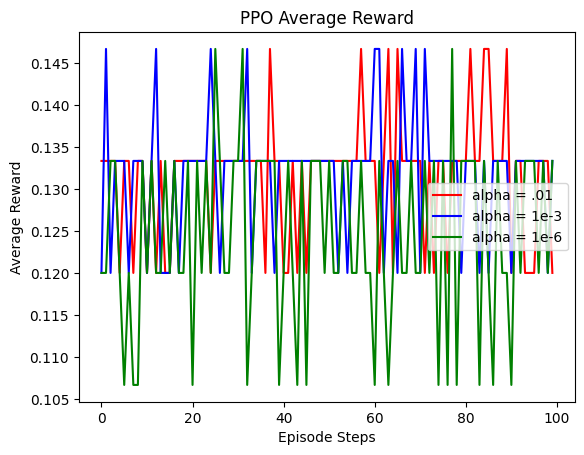

In [49]:
plt.title("PPO Average Reward")
plt.plot(first_success_rate, color = "red", label = "alpha = .01")
plt.plot(second_success_rate, color = "blue", label = "alpha = 1e-3")
plt.plot(third_success_rate, color = "green", label = "alpha = 1e-6")
plt.legend()
plt.xlabel("Episode Steps")
plt.ylabel("Average Reward")
plt.show()

In [20]:
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
import mani_skill.envs
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_checker import check_env
from mani_skill.utils import gym_utils
from mani_skill.utils.wrappers.record import RecordEpisode
from mani_skill.vector.wrappers.sb3 import ManiSkillSB3VectorEnv
import torch
import numpy as np

SEED = 17
NUM_ENVS = 8
total_timesteps = 100000
def run_a2c(env, total_timesteps, policy="MlpPolicy", learning_rate=3e-4, model_name=""):
    env = gym.make("CartPole-v1", render_mode = "rgb_array")
    states, _ = env.reset(seed = SEED, options = {"low": -0.1, "high": 0.1})
    check_env(env, warn = True)

    a2c_model = A2C("MlpPolicy", env=env, learning_rate=learning_rate, verbose=1)
    a2c_model.learn(total_timesteps=100000, progress_bar=True)
    a2c_model.save(model_name)
    print(f"Saved model: {model_name}")

In [21]:
run_a2c(env, total_timesteps, learning_rate=0.01, model_name="a2c_0.01")
run_a2c(env, total_timesteps, learning_rate=1e-3, model_name="a2c_1e-3")
run_a2c(env, total_timesteps, learning_rate=1e-6, model_name="a2c_1e-6")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 9.75      |
|    ep_rew_mean        | 9.75      |
| time/                 |           |
|    fps                | 783       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -5.97e-05 |
|    explained_variance | 0.998     |
|    learning_rate      | 0.01      |
|    n_updates          | 99        |
|    policy_loss        | 1.01e-06  |
|    value_loss         | 0.0562    |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 9.19      |
|    ep_rew_mean        | 9.19      |
| time/                 |           |
|    fps                | 782       |
|    iterations         | 200   

Saved model: a2c_0.01
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 29.1     |
|    ep_rew_mean        | 29.1     |
| time/                 |          |
|    fps                | 896      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.637   |
|    explained_variance | -0.125   |
|    learning_rate      | 0.001    |
|    n_updates          | 99       |
|    policy_loss        | -6.29    |
|    value_loss         | 127      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 27.9     |
|    ep_rew_mean        | 27.9     |
| time/                 |          |
|    fps                | 927      |
|    iterations         | 200    

Saved model: a2c_1e-3
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 20       |
|    ep_rew_mean        | 20       |
| time/                 |          |
|    fps                | 950      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | -0.00687 |
|    learning_rate      | 1e-06    |
|    n_updates          | 99       |
|    policy_loss        | 2.04     |
|    value_loss         | 10.6     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22       |
|    ep_rew_mean        | 22       |
| time/                 |          |
|    fps                | 951      |
|    iterations         | 200    

Saved model: a2c_1e-6


In [33]:
def get_average(model_name, iterations=100):
    max_episode_steps = 75
    model = A2C.load(model_name)
    eval_env = gym.make("CartPole-v1", render_mode = "rgb_array")
    obs, _ = eval_env.reset()
    success = []
    success_rate_list = []
    iterations = 100
    for iter in range(iterations):
        for i in range(max_episode_steps):
            action, _states = model.predict(obs, deterministic=True)
            # obs, rewards, dones, _, info = eval_env.step(action)
            output = eval_env.step(action)
            reward = output[1]
            
            #print(f"output {i}: {output}")
            #print(f"Reward {i}: {reward}\n")

            success.append(reward)
        success_rate = np.mean(np.array(success))
        #print(f"Success Rate: {success_rate}")
        success_rate_list.append(success_rate)
    return success_rate_list

0.006916503356852827
0.00760815369253811
0.006224853021167545


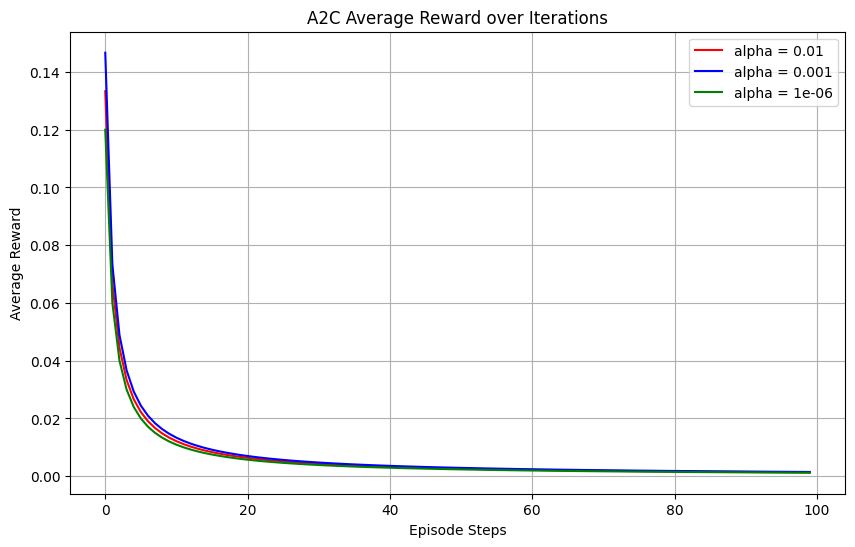

In [34]:
learning_rates = [0.01, 1e-3, 1e-6]
model_names = ["a2c_0.01", "a2c_1e-3", "a2c_1e-6"]
colors = ["red", "blue", "green"]

plt.figure(figsize=(10, 6))

for lr, model_name, color in zip(learning_rates, model_names, colors):
    success_rate_list = get_average(model_name)
    print(np.mean(success_rate_list))
    plt.plot(success_rate_list, label=f'alpha = {lr}', color=color)

plt.title("A2C Average Reward over Iterations")
plt.xlabel("Episode Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def record_video(model=None, env=None, video_name=None): 
    import os
    import imageio

    print("Recording a video...")
    video_frames = []
    obs, _ = env.reset()
    done = False

    while not done:
        frame = env.render()  # (fixed small typo: should be env.render() not eval_env.render())
        video_frames.append(frame)
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break

    env.close()

    # Save the video
    os.makedirs("videos", exist_ok=True)
    video_path = os.path.join("videos", f"{video_name}.mp4")
    imageio.mimsave(video_path, video_frames, fps=30)
    print(f"Video saved to {video_path}")

In [41]:
from stable_baselines3 import A2C

# Load your trained A2C model
a2c_001 = A2C.load("a2c_0.01")
a2c_1e_3 = A2C.load("a2c_1e-3")
a2c_1e_6 = A2C.load("a2c_1e-6")
eval_env = gym.make("CartPole-v1", render_mode="rgb_array")

# Record a video
record_video(model=a2c_001, env=eval_env, video_name="a2c_001_video")
record_video(model=a2c_1e_3, env=eval_env, video_name="a2c_1e-3_video")
record_video(model=a2c_1e_6, env=eval_env, video_name="a2c_1e-6_video")


Recording a video...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to videos\a2c_001_video.mp4
Recording a video...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to videos\a2c_1e-3_video.mp4
Recording a video...
Video saved to videos\a2c_1e-6_video.mp4


In [50]:
from stable_baselines3 import PPO

# Load your trained A2C model
ppo_001 = PPO.load("ppo_.01")
ppo_1e_3 = PPO.load("ppo_1e-3")
ppo_1e_6 = PPO.load("ppo_1e-6")
eval_env = gym.make("CartPole-v1", render_mode="rgb_array")

# Record a video
record_video(model=a2c_001, env=eval_env, video_name="ppo_001_video")
record_video(model=a2c_1e_3, env=eval_env, video_name="ppo_1e-3_video")
record_video(model=a2c_1e_6, env=eval_env, video_name="ppo_1e-6_video")

Recording a video...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to videos\ppo_001_video.mp4
Recording a video...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to videos\ppo_1e-3_video.mp4
Recording a video...
Video saved to videos\ppo_1e-6_video.mp4
